In [ ]:
# Import necessary libraries for data handling, visualization, NLP, and ML
import pandas as pd
import numpy as np
import re
import string
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
from sklearn.utils import shuffle

# Download required NLTK resources for lemmatization
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
# Load dataset from GitHub
DATA_URL = 'https://raw.githubusercontent.com/dD2405/Twitter_Sentiment_Analysis/master/train.csv'
df = pd.read_csv(DATA_URL)

In [ ]:
# Drop nulls and rename columns for consistency
# We're interested in the sentiment and text only
# Drop NaN values and reset index

df = df[['label', 'tweet']].dropna().reset_index(drop=True)
df.columns = ['sentiment', 'text']

In [ ]:
# Define a static list of stopwords to remove common but uninformative words
STATIC_STOPWORDS = set([
    'a', 'about', 'above', 'after', 'again', 'against', 'all', 'am', 'an', 'and',
    'any', 'are', 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below',
    'between', 'both', 'but', 'by', 'could', 'did', 'do', 'does', 'doing', 'down',
    'during', 'each', 'few', 'for', 'from', 'further', 'had', 'has', 'have', 'having',
    'he', 'her', 'here', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'i',
    'if', 'in', 'into', 'is', 'it', 'its', 'itself', 'just', 'me', 'more', 'most',
    'my', 'myself', 'no', 'nor', 'not', 'now', 'of', 'off', 'on', 'once', 'only',
    'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 'same', 'she',
    'should', 'so', 'some', 'such', 'than', 'that', 'the', 'their', 'theirs',
    'them', 'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 'through',
    'to', 'too', 'under', 'until', 'up', 'very', 'was', 'we', 'were', 'what', 'when',
    'where', 'which', 'while', 'who', 'whom', 'why', 'with', 'would', 'you', 'your',
    'yours', 'yourself', 'yourselves'
])

lemmatizer = WordNetLemmatizer()

In [ ]:
# Text cleaning by removing URLs, non-alphabetic characters, stopwords, and applying lemmatization
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in STATIC_STOPWORDS]
    return ' '.join(tokens)

df['cleaned'] = df['text'].apply(clean_text)

In [ ]:
# Balance the dataset so each sentiment class has equal representation (helps prevent bias)
def balance_classes(df, target_col='sentiment'):
    if df.empty or df[target_col].dropna().empty:
        raise ValueError("Input dataframe or target column is empty.")
    classes = df[target_col].unique()
    counts = df[target_col].value_counts()
    majority_class = counts.idxmax()
    majority_df = df[df[target_col] == majority_class]
    balanced = [majority_df]

    for cls in classes:
        if cls != majority_class:
            cls_df = df[df[target_col] == cls]
            upsampled = cls_df.sample(len(majority_df), replace=True, random_state=42)
            balanced.append(upsampled)
    result = pd.concat(balanced)
    return result

df = balance_classes(df)
df = shuffle(df, random_state=42).reset_index(drop=True)

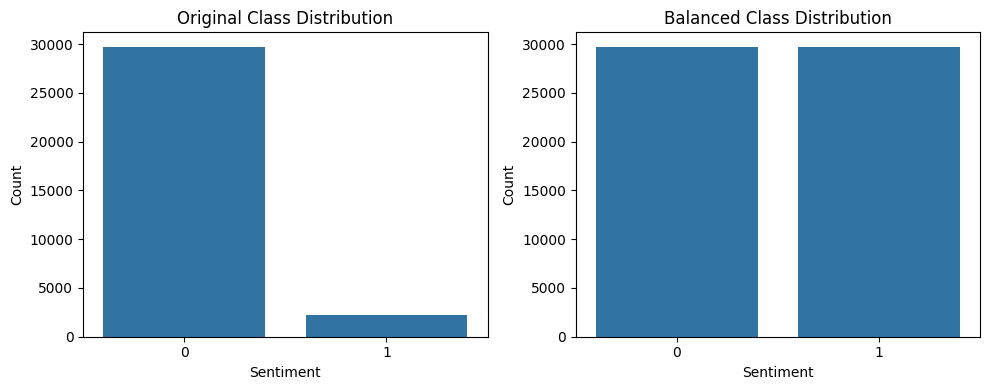

In [ ]:
# Visualize class distribution to understand class imbalance impact:-

# Before balancing
original_df = pd.read_csv(DATA_URL)[['label', 'tweet']].dropna()
original_df.columns = ['sentiment', 'text']

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.countplot(x='sentiment', data=original_df)
plt.title("Original Class Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")

# After balancing
plt.subplot(1, 2, 2)
sns.countplot(x='sentiment', data=df)
plt.title("Balanced Class Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [ ]:
# Split dataset into training and testing sets to evaluate model generalization
X_train, X_test, y_train, y_test = train_test_split(
    df['cleaned'], df['sentiment'], test_size=0.2, random_state=42)

In [ ]:
# Convert cleaned text into numerical features using TF-IDF (with unigrams to trigrams)
vectorizer = TfidfVectorizer(ngram_range=(1,3), max_features=10000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [ ]:
# Logistic Regression with class balancing
model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(X_train_vec, y_train)

y_pred = model.predict(X_test_vec)

def convert_label(label):
    return "Negative (1)" if label == 1 else "Positive (0)"

converted_y_test = [convert_label(val) for val in y_test]
converted_y_pred = [convert_label(val) for val in y_pred]

# Output classification metrics to evaluate model performance
print("Accuracy:", accuracy_score(converted_y_test, converted_y_pred))
print(classification_report(converted_y_test, converted_y_pred))

Accuracy: 0.9644179004037685
              precision    recall  f1-score   support

Negative (1)       0.95      0.99      0.97      5989
Positive (0)       0.98      0.94      0.96      5899

    accuracy                           0.96     11888
   macro avg       0.97      0.96      0.96     11888
weighted avg       0.97      0.96      0.96     11888



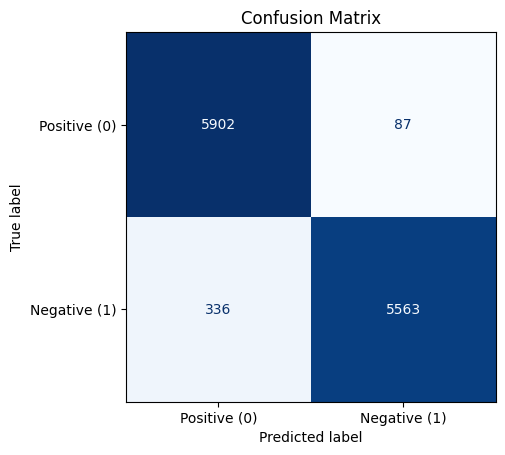

In [ ]:
# Display confusion matrix to visualize model's prediction breakdown
# Shows how many actual positives/negatives were correctly/incorrectly predicted

ConfusionMatrixDisplay.from_predictions(
    converted_y_test, converted_y_pred,
    display_labels=["Positive (0)", "Negative (1)"],
    cmap='Blues',
    colorbar=False
)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Predict custom input
def predict_sentiment(text):
    cleaned = clean_text(text)
    vec = vectorizer.transform([cleaned])
    pred = model.predict(vec)[0]
    return convert_label(pred)

In [ ]:
# Example usage:
# print(predict_sentiment("<YOUR_SENTENCE>"))

print(predict_sentiment("i love it"))
print(predict_sentiment("commit criminal activities"))
print(predict_sentiment("i hate it"))
print(predict_sentiment("he is a very good lawyer"))

Positive (0)
Negative (1)
Negative (1)
Positive (0)
